## Imports

In [1]:
import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from analysis.chiefinvestigation import Chiefinvestigator
from analysis.sindy_autoencoder import control_autoencoder, utils
from jax.experimental import optimizers
from jax import random
import time

os.chdir("../../")  # remove if you want to search for ids in the analysis directory
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.getcwd()

'/home/raphael/Code/dexterous-robot-hand'

## Generate Training and Testing Data from Episodes
One Episode of InvertedPendulum (MuJoCoEnv) lasts 1000 timesteps. E.g. 500 episodes generate 500,000 
timesteps to be used as training and testing datasets.

In [2]:
agent_id = 1607352660 # inverted pendulum no vel, continuous action

chiefinv = Chiefinvestigator(agent_id)
# collect data from episodes
n_episodes = 20
activations_all_episodes, inputs_all_episodes, actions_all_episodes, states_all_episodes, _ \
    = chiefinv.get_data_over_episodes(n_episodes, "policy_recurrent_layer", chiefinv.get_layer_names()[1])
print(f"SIMULATED {n_episodes} episodes")

# create training and testing datasets
training_size = int(len(inputs_all_episodes) * 0.8)
dx = np.gradient(activations_all_episodes, axis=0)
training_data = {'x': activations_all_episodes[:training_size, :],
                 'dx': dx[:training_size, :],
                 'u': inputs_all_episodes[:training_size, :]}
testing_data = {'x': activations_all_episodes[training_size:, :],
                'dx': dx[training_size:, :],
                'u': inputs_all_episodes[training_size:, :]}
# TODO: visualize the data

storage/saved_models/states//1607352660
Loading from iteration best.
Using CombiWrapper('StateNormalizationWrapper', 'RewardNormalizationWrapper') for preprocessing.
SIMULATED 20 episodes


## Set up SindyControlAutoencoder 

In [3]:
layers = [64, 32, 8, 4]
poly_order = 2
lib_size = control_autoencoder.library_size(layers[-1], poly_order, include_control=True)
key = random.PRNGKey(123)

thresholding_frequency, coefficient_theshold = 500, 0.1
hps = {'system_loss_coeff': 1,
       'control_loss_coeff': 1,
       'dx_loss_weight': 1e-4,
       'dz_loss_weight': 1e-6,
       'reg_loss_weight': 1e-5}

batch_size = 2000
num_batches = int(jnp.ceil(len(training_data['x']) / batch_size))

init_params, coefficient_mask = control_autoencoder.build_sindy_control_autoencoder(layers, lib_size, key)

## Plot Coefficients and Coefficient Mask

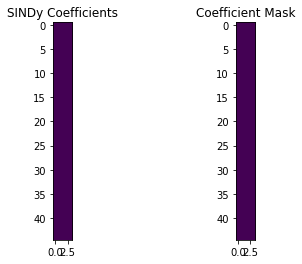

In [4]:
control_autoencoder.plot_params(init_params, coefficient_mask)

## Set up Optimizer

In [5]:
learning_rate = 1e-3
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(init_params)

## Train the networks

In [9]:
n_epochs, n_refine_epochs = 500, 100
print_every = 200 # epochs
all_train_losses = []

start_time = time.time()
for epoch in range(n_epochs):
    for batch in range(num_batches):
        ids = utils.batch_indices(batch, num_batches, batch_size)
        opt_state = control_autoencoder.update_jit(batch, opt_state, opt_update, get_params,
                                                   training_data['x'][ids, :],
                                                   training_data['dx'][ids, :],
                                                   training_data['u'][ids, :], coefficient_mask, hps)

    params = get_params(opt_state)
    if epoch % thresholding_frequency == 0 and epoch > 1:
        coefficient_mask = jnp.abs(params['sindy_coefficients']) > coefficient_theshold
        print("Updated coefficient mask")

    all_train_losses.append(control_autoencoder.loss_jit(params,
                                                         training_data['x'][:batch_size, :],
                                                         training_data['dx'][:batch_size, :],
                                                         training_data['u'][:batch_size, :], coefficient_mask, hps))
    if epoch % print_every == 0:
        utils.print_update(all_train_losses[-1]['total'], epoch, epoch*num_batches, time.time() - start_time)
        start_time = time.time()

print(f"FINISHING TRAINING...\n"
      f"Sparsity: {jnp.sum(coefficient_mask)} active terms")

all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Epoch 1 | Loss 0.17161770164966583 | Updates 0 | This took: 0.0212s
Epoch 201 | Loss 0.09464020282030106 | Updates 1600 | This took: 3.193s
Epoch 401 | Loss 0.06476189941167831 | Updates 3200 | This took: 3.0262s
FINISHING TRAINING...
Sparsity: 180.0 active terms


## Plot Training Losses

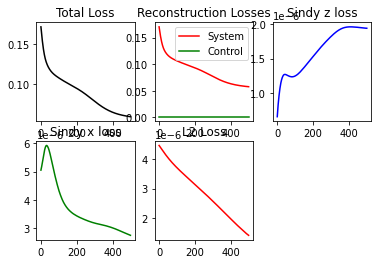

In [12]:
time_steps = np.linspace(0, n_epochs, n_epochs)
plt.figure()
plt.subplot(231)
plt.plot(time_steps, all_train_losses['total'], 'k')
plt.title('Total Loss')

plt.subplot(232)
plt.plot(time_steps, all_train_losses['sys_loss'], 'r', label='System')
plt.plot(time_steps, all_train_losses['control_loss'], 'g', label='Control')
plt.legend()
plt.title('Reconstruction Losses')

plt.subplot(233)
plt.plot(time_steps, all_train_losses['sindy_z_loss'], 'b')
plt.title('Sindy z loss')

plt.subplot(234)
plt.plot(time_steps, all_train_losses['sindy_x_loss'], 'g')
plt.title('Sindy x loss')

plt.subplot(235)
plt.plot(time_steps, all_train_losses['sindy_regularization_loss'], 'r')
plt.title('L2 Loss')
plt.show()

## Refinement Training

In [ ]:
hps['reg_loss_weight'] = 0 # no regularization
print('REFINEMENT...')
all_refine_losses = []

start_time = time.time()
for epoch in range(n_refine_epochs):
    for batch in range(num_batches):
        ids = utils.batch_indices(batch, num_batches, batch_size)
        opt_state = control_autoencoder.update_jit(batch, opt_state, opt_update, get_params,
                                                   training_data['x'][ids, :],
                                                   training_data['dx'][ids, :],
                                                   training_data['u'][ids, :], coefficient_mask, hps)

    all_refine_losses.append(control_autoencoder.loss_jit(get_params(opt_state),
                                                          training_data['x'][:batch_size, :],
                                                          training_data['dx'][:batch_size, :],
                                                          training_data['u'][:batch_size, :], coefficient_mask, hps))

    utils.print_update(all_train_losses[-1]['total'], epoch, epoch*num_batches, time.time() - start_time)
    start_time = time.time()

all_refine_losses = {k: [dic[k] for dic in all_refine_losses] for k in all_refine_losses[0]}

## Testing

In [ ]:
params = get_params(opt_state)
test_batch_size = 10000 # 10 episodes
test_loss = control_autoencoder.loss_jit(params,
                                         testing_data['x'][:test_batch_size, :],
                                         testing_data['dx'][:test_batch_size, :],
                                         testing_data['u'][:test_batch_size, :],
                                         coefficient_mask, hps)['total']
print(f"Loss on large test batch: {round(test_loss, 6)}")

## Visualizations